In [1]:
import os, glob, json
from brain_atlas_toolkit import graph_tools
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from patsy import dmatrix

In [2]:
# Load Allen JSON
allen_json_file = "/jukebox/LightSheetTransfer/atlas/allen_atlas/allen.json"
with open(allen_json_file,'r') as infile:
    ontology_dict = json.load(infile)

In [3]:
# Make the ontology graph 
ontology_graph = graph_tools.Graph(ontology_dict)

## Prep lavision

In [4]:
lavision_dir = "/jukebox/wang/seagravesk/lightsheet/cfos_raw_images/combined_dorsal_up_and_ventral_up_analysis"

In [5]:
lavision_animal_dirs = glob.glob(lavision_dir + "/*")

In [6]:
all_dfs = []
for animal_dir in lavision_animal_dirs:
    print(animal_dir)
    animal_id = os.path.basename(animal_dir)
    csv_file = os.path.join(animal_dir,"allen_id_table_with_anatomical_assignment_of_cell_counts_80um_eroded_vols.csv")
    df = pd.read_csv(csv_file)
    df_pivot = df.pivot(columns='name',values='cell_count').bfill().iloc[[0],:]
    df_pivot.index.names = ['Animal_id']
    df_pivot.index = [animal_id]
    if 'observ' in animal_id:
        condition = 'observer'
    elif 'demons' in animal_id:
        condition = 'demonstrator'
    else:
        condition = 'control'
    df_pivot.insert(0,'condition',[condition])
    all_dfs.append(df_pivot)


/jukebox/wang/seagravesk/lightsheet/cfos_raw_images/combined_dorsal_up_and_ventral_up_analysis/f37106_mouse1
/jukebox/wang/seagravesk/lightsheet/cfos_raw_images/combined_dorsal_up_and_ventral_up_analysis/m37109_mouse2
/jukebox/wang/seagravesk/lightsheet/cfos_raw_images/combined_dorsal_up_and_ventral_up_analysis/m37072_observ
/jukebox/wang/seagravesk/lightsheet/cfos_raw_images/combined_dorsal_up_and_ventral_up_analysis/f37080_mouse2
/jukebox/wang/seagravesk/lightsheet/cfos_raw_images/combined_dorsal_up_and_ventral_up_analysis/m37083_demons
/jukebox/wang/seagravesk/lightsheet/cfos_raw_images/combined_dorsal_up_and_ventral_up_analysis/m37071_observ
/jukebox/wang/seagravesk/lightsheet/cfos_raw_images/combined_dorsal_up_and_ventral_up_analysis/f37080_mouse1
/jukebox/wang/seagravesk/lightsheet/cfos_raw_images/combined_dorsal_up_and_ventral_up_analysis/f37107_demons
/jukebox/wang/seagravesk/lightsheet/cfos_raw_images/combined_dorsal_up_and_ventral_up_analysis/f37078_observ
/jukebox/wang/seagr

In [7]:
combined_lavision_df = pd.concat(all_dfs,axis=0)

In [8]:
combined_lavision_df

name,condition,Abducens nucleus,Accessory abducens nucleus,Accessory facial motor nucleus,Accessory olfactory bulb,"Accessory olfactory bulb, glomerular layer","Accessory olfactory bulb, granular layer","Accessory olfactory bulb, mitral layer",Accessory supraoptic group,Accessory trigeminal nucleus,...,ventral roots,ventral spinocerebellar tract,ventral spinothalamic tract,ventral tegmental decussation,ventricular systems,ventrolateral hypothalamic tract,vestibular nerve,vestibulocochlear nerve,vestibulospinal pathway,vomeronasal nerve
f37106_mouse1,control,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
m37109_mouse2,control,0.0,0.0,0.0,0.0,3.0,0.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
m37072_observ,observer,0.0,0.0,0.0,0.0,0.0,1.0,6.0,0.0,0.0,...,0.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0
f37080_mouse2,control,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
m37083_demons,demonstrator,0.0,0.0,0.0,0.0,3.0,3.0,1.0,0.0,0.0,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
m37071_observ,observer,0.0,0.0,0.0,0.0,2.0,2.0,14.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
f37080_mouse1,control,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
f37107_demons,demonstrator,0.0,0.0,0.0,0.0,15.0,3.0,18.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,5.0,0.0,0.0,0.0
f37078_observ,observer,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0
f37077_demons,demonstrator,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0


OK now we have the NxK dataframe. However, the counts in each region are only the counts that overlap with the shell of each region. To get the true counts, need to add all of the counts in the progeny of each region to the counts listed for each region. 

In [9]:
brain_regions = combined_lavision_df.iloc[:,1:]

In [13]:
# Loop over regions and add the counts of the progeny of each region to its current cell count
corrected_lavision_df = combined_lavision_df.copy()
corrected_lavision_df.iloc[:,1:]=0
for ii,brain_region in enumerate(brain_regions):
    counts_shell = combined_lavision_df[brain_region]
    progeny = ontology_graph.get_progeny(brain_region)
    counts_prog = combined_lavision_df[progeny].sum(axis=1)
    counts_corrected = counts_shell + counts_prog
    corrected_lavision_df[brain_region] = counts_corrected

In [14]:
corrected_lavision_df

name,condition,Abducens nucleus,Accessory abducens nucleus,Accessory facial motor nucleus,Accessory olfactory bulb,"Accessory olfactory bulb, glomerular layer","Accessory olfactory bulb, granular layer","Accessory olfactory bulb, mitral layer",Accessory supraoptic group,Accessory trigeminal nucleus,...,ventral roots,ventral spinocerebellar tract,ventral spinothalamic tract,ventral tegmental decussation,ventricular systems,ventrolateral hypothalamic tract,vestibular nerve,vestibulocochlear nerve,vestibulospinal pathway,vomeronasal nerve
f37106_mouse1,control,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3085.0,0.0,0.0,72.0,0.0,0.0
m37109_mouse2,control,0.0,0.0,0.0,6.0,3.0,0.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2852.0,0.0,1.0,66.0,0.0,0.0
m37072_observ,observer,0.0,0.0,0.0,7.0,0.0,1.0,6.0,0.0,0.0,...,0.0,0.0,0.0,2.0,2796.0,0.0,1.0,119.0,0.0,0.0
f37080_mouse2,control,0.0,0.0,0.0,2.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1653.0,0.0,2.0,129.0,0.0,0.0
m37083_demons,demonstrator,0.0,0.0,0.0,7.0,3.0,3.0,1.0,0.0,0.0,...,0.0,0.0,0.0,2.0,1916.0,0.0,0.0,80.0,0.0,0.0
m37071_observ,observer,0.0,0.0,0.0,18.0,2.0,2.0,14.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1651.0,0.0,1.0,109.0,0.0,0.0
f37080_mouse1,control,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1730.0,0.0,0.0,24.0,0.0,0.0
f37107_demons,demonstrator,0.0,0.0,0.0,36.0,15.0,3.0,18.0,0.0,0.0,...,0.0,0.0,0.0,3.0,2662.0,0.0,5.0,102.0,0.0,0.0
f37078_observ,observer,0.0,0.0,0.0,3.0,1.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1452.0,0.0,3.0,36.0,0.0,0.0
f37077_demons,demonstrator,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2249.0,0.0,2.0,55.0,0.0,0.0


## A test: Control vs. observer (LaVision) for a single region

In [16]:
all_predictors = corrected_lavision_df[['condition']]
all_counts = corrected_lavision_df.iloc[:,1:].astype(int)

In [17]:
 # Find all entries from either conditon
condition1 = 'control'
condition2 = 'observer'
condition_mask = (all_predictors['condition']==condition1) | (all_predictors['condition']==condition2)
predictors = all_predictors.loc[condition_mask,:]
counts = all_counts.loc[condition_mask,:]

In [19]:
counts

name,Abducens nucleus,Accessory abducens nucleus,Accessory facial motor nucleus,Accessory olfactory bulb,"Accessory olfactory bulb, glomerular layer","Accessory olfactory bulb, granular layer","Accessory olfactory bulb, mitral layer",Accessory supraoptic group,Accessory trigeminal nucleus,Agranular insular area,...,ventral roots,ventral spinocerebellar tract,ventral spinothalamic tract,ventral tegmental decussation,ventricular systems,ventrolateral hypothalamic tract,vestibular nerve,vestibulocochlear nerve,vestibulospinal pathway,vomeronasal nerve
f37106_mouse1,0,0,0,1,0,1,0,0,0,134,...,0,0,0,0,3085,0,0,72,0,0
m37109_mouse2,0,0,0,6,3,0,3,0,0,318,...,0,0,0,0,2852,0,1,66,0,0
m37072_observ,0,0,0,7,0,1,6,0,0,625,...,0,0,0,2,2796,0,1,119,0,0
f37080_mouse2,0,0,0,2,1,1,0,0,0,469,...,0,0,0,0,1653,0,2,129,0,0
m37071_observ,0,0,0,18,2,2,14,0,0,270,...,0,0,0,0,1651,0,1,109,0,0
f37080_mouse1,0,0,0,1,0,0,1,0,0,148,...,0,0,0,0,1730,0,0,24,0,0
f37078_observ,0,0,0,3,1,2,0,0,0,384,...,0,0,0,0,1452,0,3,36,0,0
f37105_observ,0,0,0,1,0,1,0,0,0,319,...,0,0,0,0,2635,0,2,32,0,0
m37081_observ,0,0,0,1,0,0,1,0,0,120,...,0,0,0,5,2209,0,1,124,0,0
f37070_observ,0,0,0,38,6,8,24,0,0,285,...,0,0,0,0,1422,0,2,81,0,0


In [21]:
# Get rid of regions that don't have any counts in any of the brains in this subset
good_regions_mask = counts.sum(axis=0)>0
good_counts = counts.loc[:,good_regions_mask]
good_counts

name,Accessory olfactory bulb,"Accessory olfactory bulb, glomerular layer","Accessory olfactory bulb, granular layer","Accessory olfactory bulb, mitral layer",Agranular insular area,"Agranular insular area, dorsal part","Agranular insular area, dorsal part, layer 2/3","Agranular insular area, dorsal part, layer 5","Agranular insular area, dorsal part, layer 6a","Agranular insular area, posterior part",...,superior cerebelar peduncles,superior cerebellar peduncle decussation,superior colliculus commissure,third ventricle,trapezoid body,trigeminal nerve,ventral tegmental decussation,ventricular systems,vestibular nerve,vestibulocochlear nerve
f37106_mouse1,1,0,1,0,134,41,1,26,14,83,...,4,0,0,68,56,166,0,3085,0,72
m37109_mouse2,6,3,0,3,318,40,1,16,23,260,...,1,0,0,94,45,626,0,2852,1,66
m37072_observ,7,0,1,6,625,198,4,61,133,259,...,0,0,0,140,95,538,2,2796,1,119
f37080_mouse2,2,1,1,0,469,114,13,52,49,279,...,0,0,0,53,117,513,0,1653,2,129
m37071_observ,18,2,2,14,270,128,6,12,110,100,...,1,0,1,33,85,755,0,1651,1,109
f37080_mouse1,1,0,0,1,148,35,14,14,7,92,...,0,0,0,47,18,469,0,1730,0,24
f37078_observ,3,1,2,0,384,127,5,55,67,218,...,0,0,1,54,29,1197,0,1452,3,36
f37105_observ,1,0,1,0,319,96,4,64,28,188,...,0,0,2,91,0,1047,0,2635,2,32
m37081_observ,1,0,0,1,120,35,0,8,27,61,...,0,0,2,122,111,751,5,2209,1,124
f37070_observ,38,6,8,24,285,112,3,24,85,133,...,0,0,0,72,68,307,0,1422,2,81


In [23]:
assert len(predictors) == len(good_counts)
assert len(predictors) > 0
print(len(predictors))

25


In [24]:
# Use Paty's neat dmatrix() function to create the "design matrix"
# This converts the batch and condition values which are categorical in nature\
# into numeric values
# 
# We only need to do this once per batch/condition combo 
design_matrix = dmatrix("condition", predictors,return_type='dataframe')

In [25]:
# Do the test for an example brain region
brain_regions = good_counts.columns
brain_region = brain_regions[0]
brain_region

'Accessory olfactory bulb'

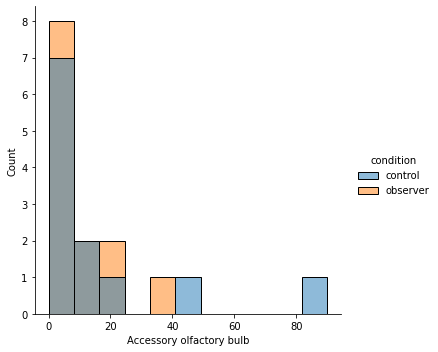

In [26]:
sns.displot(pd.concat([predictors,good_counts],axis=1), x=brain_region, hue="condition")

## Negative binomial regression for a single brain region (test)

In [27]:
rowsums=np.sum(good_counts,axis=1)

In [28]:
offsets = np.log(rowsums)

In [29]:
counts_thisregion = good_counts[brain_region]

In [30]:
# Make the negative binomial model and fit it
nb_mod = sm.GLM(counts_thisregion, design_matrix,family=sm.families.NegativeBinomial(),offset=offsets)
nb_fit = nb_mod.fit()

In [ ]:
sm.GLM?

In [31]:
# Print out a summary of the fit
nb_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Generalized Linear Model Regression Results                     
====================================================================================
Dep. Variable:     Accessory olfactory bulb   No. Observations:                   25
Model:                                  GLM   Df Residuals:                       23
Model Family:              NegativeBinomial   Df Model:                            1
Link Function:                          log   Scale:                          1.0000
Method:                                IRLS   Log-Likelihood:                -89.094
Date:                      Wed, 01 Sep 2021   Deviance:                       35.718
Time:                              16:52:56   Pearson chi2:                     40.5
No. Iterations:                           6                                         
Covariance Type:                  nonrobust                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept               -10.8174      0.297    -36.457      0.000     -11.399     -10.236
condition[T.observer]    -0.6611      0.417     -1.587      0.113      -1.478       0.155
=========================================================================================
"""

## Prep SmartSPIM

In [49]:
smartspim_dir = "/jukebox/wang/seagravesk/lightsheet/smartspim_points_202107"

In [50]:
smartspim_animal_dirs = glob.glob(smartspim_dir + "/*")

In [51]:
all_smartspim_dfs = []
for animal_dir in smartspim_animal_dirs:
    animal_id = '_'.join(os.path.basename(animal_dir).split('_')[0:3])
    print(animal_id)
    csv_file = os.path.join(animal_dir,"allen_id_table_with_anatomical_assignment_of_cell_counts.csv")
    df = pd.read_csv(csv_file)
    df_pivot = df.pivot(columns='name',values='cell_count').bfill().iloc[[0],:]
    df_pivot.index.names = ['Animal_id']
    df_pivot.index = [animal_id]
    if 'observ' in animal_id:
        condition = 'observer'
    elif 'demons' in animal_id:
        condition = 'demonstrator'
    else:
        condition = 'control'
    df_pivot.insert(0,'condition',[condition])
    all_smartspim_dfs.append(df_pivot)


m37071_observer_20171006
f37105_observer_20171012
f37078_observer_20171014
f37104_demonstrator_20171016
f37077_demonstrator_20171011
f37070_observer_20171007
f37106_mouse1_20171011
m37079_mouse1_20171014
m37081_demonstrator_20171014
m37113_mouse1_20171007
m37109_mouse1_20171018
f37070_demonstrator_20171007
m37110_demonstrator_20171016
f37104_observer_20171016
f37107_observer_20171007
m37071_demonstrator_20171006
f37105_demonstrator_20171012
f37080_mouse1_20171015
f37073_mouse1_20171010
m37083_observer_20171018
m37072_demonstrator_20171008
m37111_observer_20171012
m37113_mouse2_20171007
f37107_demonstrator_20171007
f37073_mouse2_20171010
m37112_observer_20171010
f37077_observer_20171011
m37083_demonstrator_20171018
f37106_mouse2_20171011
m37081_observer_20171014
f37080_mouse2_20171015
m37079_mouse2_20171014
m37109_mouse2_20171018
m37111_demonstrator_20171012
m37110_observer_20171016
m37072_observer_20171008
m37112_demonstrator_20171010


In [52]:
combined_smartspim_df = pd.concat(all_smartspim_dfs,axis=0)

In [53]:
# Loop over regions and add the counts of the progeny of each region to its current cell count
brain_regions = combined_smartspim_df.iloc[:,1:]
corrected_smartspim_df = combined_smartspim_df.copy()
corrected_smartspim_df.iloc[:,1:]=0
for ii,brain_region in enumerate(brain_regions):
    counts_shell = combined_smartspim_df[brain_region]
    progeny = ontology_graph.get_progeny(brain_region)
    counts_prog = combined_smartspim_df[progeny].sum(axis=1)
    counts_corrected = counts_shell + counts_prog
    corrected_smartspim_df[brain_region] = counts_corrected

# Run the regression over all brain regions

In [39]:
def bh_correction(p_values,debug=False):
    """ 
    ---DESCRIPTION---
    Benjamini-Hochberg correction of p-values
    This is not well tested. 
    ---INPUT---
    p_values:           a list of p-values, can be unsorted but must not have nans
    ---OUTPUT---
    adjusted_p_values:  a list of adjusted p-values sorted from lowest to highest
    """
    # sort the p-values
    sorted_p_values = sorted(p_values)
    # Make an empty array to fill in
    adjusted_p_values = np.zeros_like(sorted_p_values)
    # Fill them from highest to lowest
    # First adjusted p-value is just highest p-value
    adjusted_p_values[-1] = sorted_p_values[-1]
    if debug:
        print("# rank_current, mod_current, next_highest, sorted_p_values[p_value_index], adjusted_p_value")
    for p_value_index in range(len(sorted_p_values)-2,-1,-1):
        next_highest = adjusted_p_values[p_value_index+1]
        rank_current = p_value_index+1
        mod_current = sorted_p_values[p_value_index] * (len(sorted_p_values)/rank_current)
        adjusted_p_value = min(next_highest,mod_current)
        adjusted_p_values[p_value_index] = adjusted_p_value
        if debug:
            print(rank_current,mod_current,next_highest,sorted_p_values[p_value_index],adjusted_p_value)
    return adjusted_p_values

In [45]:
def nb_regression(df,condition1,condition2,debug=False):
    """ 
    ---DESCRIPTION---
    Perform negative binomial regression between condition1 (assumed to be control) and
    condition2 (assumed to be treatment). Uses all batches found in both conditions.
    This is not well tested.
    ---INPUT---
    df:           an NxK dataframe where N rows are the animals and K are the columns, 
                  which must contain the batch, condition and counts in each brain region
    condition1:   a string describing one of the conditions in the dataframe (the control)
    condition2:   a string describing one of the conditions in the dataframe (the treatment)
    ---OUTPUT--
    nb_df:        A dataframe containing the results from the regression on all brain regions in df

    Saves to a CSV file called: '../data/{condition1}-{condition2}-counts-nbreg.csv'
    """
    print(f"Performing negative binomial regression for {condition2} against {condition1}")
    all_predictors =df[['condition']]
    all_counts = df.iloc[:,1:].astype(int)
    
    condition_mask = (all_predictors['condition']==condition1) | (all_predictors['condition']==condition2)
    predictors = all_predictors.loc[condition_mask,:]
    design_matrix = dmatrix("condition", predictors,return_type='dataframe')
    counts = all_counts.loc[condition_mask,:]
    # Get rid of regions that don't have any counts in any of the brains in this subset
    good_regions_mask = counts.sum(axis=0)>0
    counts = counts.loc[:,good_regions_mask]
    brain_regions = counts.columns

    assert len(predictors) == len(counts)
    assert len(predictors) > 0
    n_observations = len(predictors)
    print(f"Have {n_observations} observations for these two conditions")
    
    rowsums=np.sum(counts,axis=1)
    offsets = np.log(rowsums)
    result_list = []
    for ii in range(len(brain_regions)):
        brain_region=brain_regions[ii]
        result_dict = {
            'region_idx':ii,
            'control':condition1,
            'treatment':condition2,
            'region':brain_region
        }
        counts_thisregion = counts[brain_region]
        try:
            res_nb = sm.GLM(counts_thisregion, design_matrix,family=sm.families.NegativeBinomial(),offset=offsets).fit()
            estimate = res_nb.params[-1]
            stderr = res_nb.bse[-1]
            pvalue = res_nb.pvalues[-1]
            zscore = estimate/stderr
            status="success"
        except:
            estimate = np.nan
            stderr = np.nan
            pvalue = np.nan
            zscore = np.nan
            status="failed"
        result_dict['Estimate'] = estimate
        result_dict['Std. Error'] = stderr
        result_dict['z value'] = zscore
        result_dict['Pr(>|z|)'] = pvalue
        result_dict['status'] = status
        result_list.append(result_dict)
#     print(result_list)
    # Now calculate adjusted pvalues
    # First sort the whole result_list by p-value, keeping in mind that there can be nans
    sorted_result_list = sorted(result_list,
            key=lambda x: float('-inf') if np.isnan(x.get('Pr(>|z|)')) else x.get('Pr(>|z|)')) 
    sorted_p_values = np.array([d.get('Pr(>|z|)') for d in sorted_result_list])
    if debug:
        print(sorted_p_values)
    # separate out nans (which are at the beginning of the list due to how we sorted)
    p_values_clean = sorted_p_values[~np.isnan(sorted_p_values)]
    p_values_nan = sorted_p_values[np.isnan(sorted_p_values)]
    if debug:
        print(f"Have {len(p_values_clean)} clean p-values and {len(p_values_nan)} nan values")
    
    # calculate the fdr adjusted p-values
    adjusted_p_values_no_nans = bh_correction(p_values_clean,debug=debug)
    if debug:
        print(adjusted_p_values_no_nans)
    # add back the nans to the beginning of the list
    adj_p_values = np.concatenate([p_values_nan,adjusted_p_values_no_nans])
    # add the fdr adjusted p-value into the list of our results
    for ii in range(len(sorted_result_list)):
        sorted_result_list[ii]['fdr_adj_pval'] = adj_p_values[ii]
    # Finally, sort back to original order, the one using brain region index as key
    final_result_list = sorted(sorted_result_list,key=lambda x: x.get('region_idx'))
    # Make pandas dataframe to make it easier to save to file
    nb_df = pd.DataFrame(final_result_list)
    nb_df.set_index('region_idx',inplace=True)
    # reorder columns
    neworder = ['control','treatment','region','Estimate','Std. Error','z value','Pr(>|z|)','fdr_adj_pval','status']
    nb_df=nb_df.reindex(columns=neworder)
    # Save to csv
    savename = f'results/{condition1}-{condition2}-counts-nbreg.csv'
    nb_df.to_csv(savename,index=False)
    print(f"Saved {savename}")
    return nb_df

In [46]:
nb_lavision_df = nb_regression(df=corrected_lavision_df,condition1='control',condition2='observer')

Performing negative binomial regression for observer against control
Have 25 observations for these two conditions
Saved results/control-observer-counts-nbreg.csv


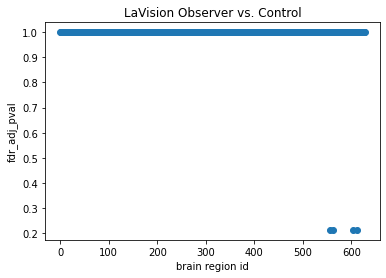

In [47]:
# Lavision adjusted p values
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(list(range(len(nb_lavision_df))),nb_lavision_df['fdr_adj_pval'])
ax.set_xlabel('brain region id')
ax.set_ylabel('fdr_adj_pval')
ax.set_title("LaVision Observer vs. Control")
savename = 'results/lavision_observer_vs_control_fdr_adj_pvalues.png'
plt.savefig(savename,format='png')

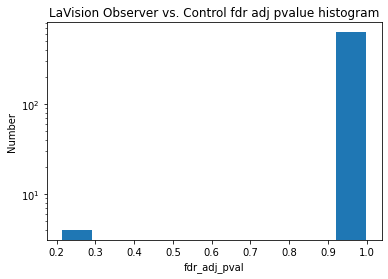

In [48]:
# Lavision adjusted p values histogram
fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist(nb_lavision_df['fdr_adj_pval'],bins=10)
ax.set_yscale('log')
ax.set_xlabel('fdr_adj_pval')
ax.set_ylabel('Number')
ax.set_title("LaVision Observer vs. Control fdr adj pvalue histogram")
savename = 'results/lavision_observer_vs_control_fdr_adj_pvalues_hist.png'
plt.savefig(savename,format='png')

In [54]:
nb_smartspim_df = nb_regression(df=corrected_smartspim_df,condition1='control',condition2='observer')

Performing negative binomial regression for observer against control
Have 25 observations for these two conditions
Saved results/control-observer-counts-nbreg.csv


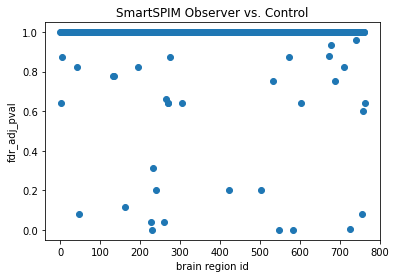

In [55]:
# Smartspim adjusted p values
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(list(range(len(nb_smartspim_df))),nb_smartspim_df['fdr_adj_pval'])
ax.set_xlabel('brain region id')
ax.set_ylabel('fdr_adj_pval')
ax.set_title("SmartSPIM Observer vs. Control")
savename = 'results/smartspim_observer_vs_control_fdr_adj_pvalues.png'
plt.savefig(savename,format='png')

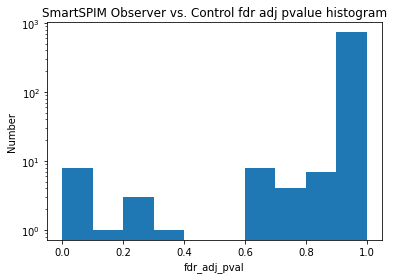

In [56]:
# Smartspim adjusted p values histogram
fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist(nb_smartspim_df['fdr_adj_pval'],bins=10)
ax.set_yscale('log')
ax.set_xlabel('fdr_adj_pval')
ax.set_ylabel('Number')
ax.set_title("SmartSPIM Observer vs. Control fdr adj pvalue histogram")
savename = 'results/smartspim_observer_vs_control_fdr_adj_pvalues_hist.png'
plt.savefig(savename,format='png')

Which regions are significant and what are the actual counts in those groups?

In [57]:
all_counts_lavision_control = corrected_lavision_df[corrected_lavision_df['condition']=='control'].iloc[:,1:].values.flatten()
all_counts_lavision_observer = corrected_lavision_df[corrected_lavision_df['condition']=='observer'].iloc[:,1:].values.flatten()

In [58]:
all_counts_smartspim_control = corrected_smartspim_df[corrected_smartspim_df['condition']=='control'].iloc[:,1:].values.flatten()
all_counts_smartspim_observer = corrected_smartspim_df[corrected_smartspim_df['condition']=='observer'].iloc[:,1:].values.flatten()

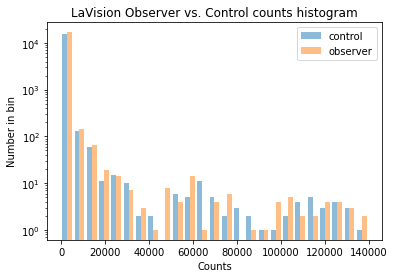

In [60]:
# Lavision counts histogram
fig = plt.figure()
ax = fig.add_subplot(111)
f,bins,_=ax.hist([all_counts_lavision_control,all_counts_lavision_observer],
                 bins=25,alpha=0.5,label=['control','observer'])
# ax.hist(all_counts_lavision_observer,bins=bins,alpha=0.5)
ax.set_yscale('log')
ax.set_xlabel('Counts')
ax.set_ylabel('Number in bin')
ax.set_yscale('log')
ax.set_title("LaVision Observer vs. Control counts histogram")
ax.legend(loc='upper right')
savename = 'results/lavision_observer_vs_control_counts_hist.png'
plt.savefig(savename,format='png')

In [68]:
# Which regions came up as significant?
nb_smartspim_significant_df = nb_smartspim_df.loc[nb_smartspim_df['fdr_adj_pval']<0.05,:]
nb_smartspim_significant_df

,control,treatment,region,Estimate,Std. Error,z value,Pr(>|z|),fdr_adj_pval,status
region_idx,,,,,,,,,
228,control,observer,Lateral dorsal nucleus of thalamus,-1.448636,0.400664,-3.615587,2.996680e-04,0.040250,success
230,control,observer,Lateral habenula,-2.037556,0.401361,-5.076611,3.842273e-07,0.000147,success
260,control,observer,Magnocellular reticular nucleus,-1.445884,0.401479,-3.601396,3.165133e-04,0.040250,success
547,control,observer,Subfornical organ,-2.122371,0.413065,-5.138106,2.775214e-07,0.000147,success
583,control,observer,Suprachiasmatic nucleus,2.080750,0.426268,4.881319,1.053784e-06,0.000268,success
725,control,observer,posterior commissure,-1.718452,0.405043,-4.242639,2.209070e-05,0.004214,success


Lateral dorsal nucleus of thalamus
Lateral habenula
Magnocellular reticular nucleus
Subfornical organ
Suprachiasmatic nucleus
posterior commissure


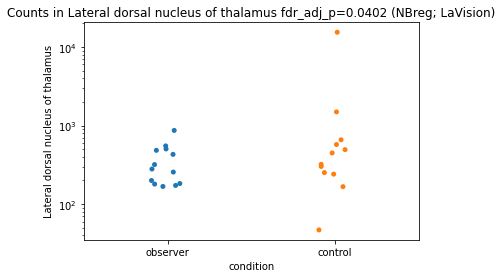

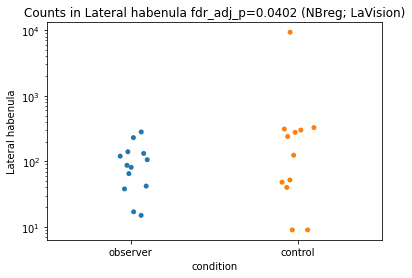

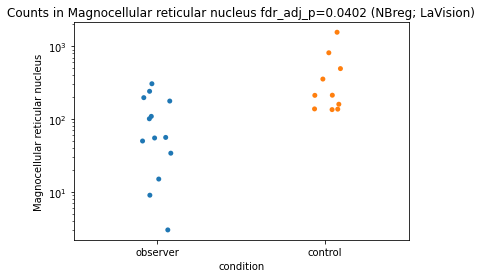

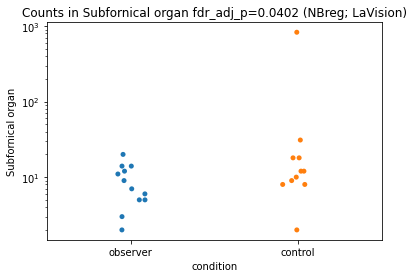

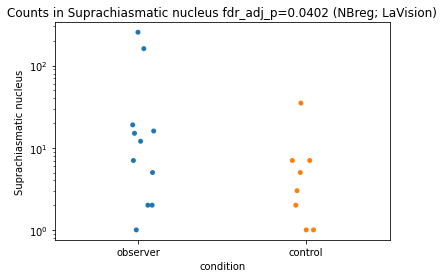

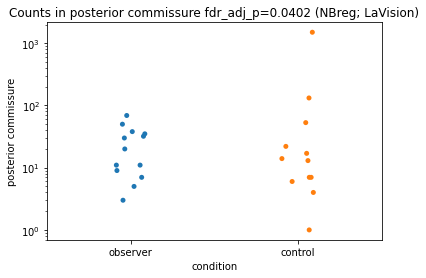

In [91]:
for region in nb_smartspim_significant_df['region']:
    fdr_adj_pval = nb_smartspim_significant_df['fdr_adj_pval'].iloc[0]
    print(region)
    # for region in nb_smartspim_significant_df['region']:
    counts_significant_region_df = corrected_smartspim_df[['condition',region]]
    condition_mask = (counts_significant_region_df['condition'] == 'control') | (
        counts_significant_region_df['condition'] == 'observer')
    counts_significant_region_df = counts_significant_region_df.loc[condition_mask,:]
    fig = plt.figure()
    ax = sns.stripplot(x="condition", y=region, data=counts_significant_region_df)
    ax.set_yscale('log')
    ax.set_title(f'Counts in {region} fdr_adj_p={fdr_adj_pval:.4f} (NBreg; LaVision)')
    savename = f'results/counts_comparison_{region}_observer_vs_control_lavision.png'
    plt.savefig(savename,format='png')

In [ ]:
# SmartSPIM counts histogram
fig = plt.figure()
ax = fig.add_subplot(111)
f,bins,_=ax.hist([all_counts_smartspim_control,all_counts_smartspim_observer],
                 bins=25,alpha=0.5,label=['control','observer'])
ax.set_xlabel('Counts')
ax.set_ylabel('Number in bin')
ax.set_yscale('log')
# ax.set_xlim(0,8000)
ax.set_title("SmartSPIM Observer vs. Control counts histogram")
ax.legend(loc='upper right')
savename = 'results/smartspim_observer_vs_control_counts_hist.png'
plt.savefig(savename,format='png')

In [ ]:
master_lavision_df.condition.value_counts()

In [ ]:
master_smartspim_df.condition.value_counts()

## Linear regression

In [ ]:
def linear_regression(df,condition1,condition2,debug=True):
    """ 
    ---DESCRIPTION---
    Perform linear regression between condition1 (assumed to be control) and
    condition2 (assumed to be treatment). 
    This is not well tested.
    ---INPUT---
    df:           an NxK dataframe where N rows are the animals and K are the columns, 
                  which must contain the batch, condition and counts in each brain region
    condition1:   a string describing one of the conditions in the dataframe (the control)
    condition2:   a string describing one of the conditions in the dataframe (the treatment)
    ---OUTPUT--
    nb_df:        A dataframe containing the results from the regression on all brain regions in df

    Saves to a CSV file called: '../data/{condition1}-{condition2}-pcounts-linreg.csv'
    """
    print(f"Performing linear regression for {condition2} against {condition1}")
    all_predictors =df[['condition']]
    all_counts = df.iloc[:,1:].astype(int)
    
    brain_regions = df.columns[1:]
    
    condition_mask = (all_predictors['condition']==condition1) | (all_predictors['condition']==condition2)
    predictors = all_predictors.loc[condition_mask,:]
    design_matrix = dmatrix("condition", predictors,return_type='dataframe')
    counts = all_counts.loc[condition_mask,:]
    assert len(predictors) == len(counts)
    assert len(predictors) > 0
    n_observations = len(predictors)
    print(f"Have {n_observations} observations for these two conditions")
    
    rowsums=np.sum(counts,axis=1)
    offsets = np.log(rowsums)
    result_list = []
    for ii in range(len(brain_regions)):
        brain_region=brain_regions[ii]
        result_dict = {
            'region_idx':ii,
            'control':condition1,
            'treatment':condition2,
            'region':brain_region
        }
        counts_thisregion = counts[brain_region]
        pcounts = counts_thisregion/rowsums

        try:
            res_lr = sm.OLS(pcounts,design_matrix).fit()
            estimate = res_lr.params[-1]
            stderr = res_lr.bse[-1]
            pvalue = res_lr.pvalues[-1]
            zscore = estimate/stderr
            status="success"
        except:
            estimate = np.nan
            stderr = np.nan
            pvalue = np.nan
            zscore = np.nan
            status="failed"
        result_dict['Estimate'] = estimate
        result_dict['Std. Error'] = stderr
        result_dict['z value'] = zscore
        result_dict['Pr(>|z|)'] = pvalue
        result_dict['status'] = status
        result_list.append(result_dict)
#     print(result_list)
    # Now calculate adjusted pvalues
    # First sort the whole result_list by p-value, keeping in mind that there can be nans
    sorted_result_list = sorted(result_list,
            key=lambda x: float('-inf') if np.isnan(x.get('Pr(>|z|)')) else x.get('Pr(>|z|)')) 
    sorted_p_values = np.array([d.get('Pr(>|z|)') for d in sorted_result_list])
    if debug:
        print(sorted_p_values)
    # separate out nans (which are at the beginning of the list due to how we sorted)
    p_values_clean = sorted_p_values[~np.isnan(sorted_p_values)]
    p_values_nan = sorted_p_values[np.isnan(sorted_p_values)]
    if debug:
        print(f"Have {len(p_values_clean)} clean p-values and {len(p_values_nan)} nan values")
    
    # calculate the fdr adjusted p-values
    adjusted_p_values_no_nans = bh_correction(p_values_clean)
    if debug:
        print(adjusted_p_values_no_nans)
    # add back the nans to the beginning of the list
    adj_p_values = np.concatenate([p_values_nan,adjusted_p_values_no_nans])
    # add the fdr adjusted p-value into the list of our results
    for ii in range(len(sorted_result_list)):
        sorted_result_list[ii]['fdr_adj_pval'] = adj_p_values[ii]
    # Finally, sort back to original order, the one using brain region index as key
    final_result_list = sorted(sorted_result_list,key=lambda x: x.get('region_idx'))
    # Make pandas dataframe to make it easier to save to file
    lr_df = pd.DataFrame(final_result_list)
    lr_df.set_index('region_idx',inplace=True)
    # reorder columns
    neworder = ['control','treatment','region','Estimate','Std. Error','z value','Pr(>|z|)','fdr_adj_pval','status']
    lr_df=lr_df.reindex(columns=neworder)
    # Save to csv
    savename = f'results/{condition1}-{condition2}-counts-linreg.csv'
    lr_df.to_csv(savename,index=False)
    print(f"Saved {savename}")
    return lr_df

In [ ]:
linear_lavision_df = linear_regression(df=master_lavision_df,condition1='control',condition2='observer')

In [ ]:
linear_lavision_df

In [ ]:
linear_lavision_df[linear_lavision_df['region']=='Frontal pole, layer 1']

In [ ]:
# Lavision adjusted p values
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(list(range(len(linear_lavision_df))),linear_lavision_df['fdr_adj_pval'])
ax.set_xlabel('brain region id')
ax.set_ylabel('fdr_adj_pval')
ax.set_title("LaVision Observer vs. Control")
# savename = 'results/lavision_observer_vs_control.png'
# plt.savefig(savename,format='png')

In [ ]:
linear_smartspim_df = linear_regression(df=master_smartspim_df,condition1='control',condition2='observer')

In [ ]:
# Lavision adjusted p values
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(list(range(len(linear_smartspim_df))),linear_smartspim_df['fdr_adj_pval'])
ax.set_xlabel('brain region id')
ax.set_ylabel('fdr_adj_pval')
ax.set_title("SmartSPIM Observer vs. Control")
# savename = 'results/lavision_observer_vs_control.png'
# plt.savefig(savename,format='png')

## Observer vs. demonstrator

In [ ]:
nb_lavision_df_obs_vs_demons = nb_regression(df=master_lavision_df,condition1='observer',condition2='demonstrator')

In [ ]:
nb_smartspim_df_obs_vs_demons = nb_regression(df=master_smartspim_df,condition1='observer',condition2='demonstrator')

In [ ]:
# Lavision adjusted p values
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(list(range(len(nb_lavision_df_obs_vs_demons))),nb_lavision_df_obs_vs_demons['fdr_adj_pval'])
ax.set_xlabel('brain region id')
ax.set_ylabel('fdr_adj_pval')
ax.set_title("LaVision Demonstrator vs. Observer")
# savename = 'results/lavision_observer_vs_control.png'
# plt.savefig(savename,format='png')

In [ ]:
nb_lavision_df_obs_vs_demons['status'].value_counts()

In [ ]:
nb_lavision_df_obs_vs_demons['Estimate'].hist()
# nb_lavision_df_obs_vs_demons['Estimate'].hist()

In [ ]:
# Lavision adjusted p values
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(list(range(len(nb_smartspim_df_obs_vs_demons))),nb_smartspim_df_obs_vs_demons['fdr_adj_pval'])
ax.set_xlabel('brain region id')
ax.set_ylabel('fdr_adj_pval')
ax.set_title("SmartSPIM Demonstrator vs. Observer")
# savename = 'results/lavision_observer_vs_control.png'
# plt.savefig(savename,format='png')

In [ ]:
linear_lavision_df_obs_vs_demons = linear_regression(df=master_lavision_df,condition1='observer',condition2='demonstrator')

In [ ]:
linear_smartspim_df_obs_vs_demons = linear_regression(df=master_smartspim_df,condition1='observer',condition2='demonstrator')

In [ ]:
# Lavision adjusted p values
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(list(range(len(linear_lavision_df_obs_vs_demons))),linear_lavision_df_obs_vs_demons['fdr_adj_pval'])
ax.set_xlabel('brain region id')
ax.set_ylabel('fdr_adj_pval')
ax.set_title("LaVision Demonstrator vs. Observer (Linear Regression)")
# savename = 'results/lavision_observer_vs_control.png'
# plt.savefig(savename,format='png')

In [ ]:
# SmartSPIM adjusted p values
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(list(range(len(linear_smartspim_df_obs_vs_demons))),linear_smartspim_df_obs_vs_demons['fdr_adj_pval'])
ax.set_xlabel('brain region id')
ax.set_ylabel('fdr_adj_pval')
ax.set_title("SmartSPIM Demonstrator vs. Observer (Linear Regression)")
# savename = 'results/lavision_observer_vs_control.png'
# plt.savefig(savename,format='png')